In [1]:
from datetime import datetime
import pandas as pd
import pandas_datareader.data as web

from statsmodels.regression.rolling import RollingOLS
import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
sns.set_style('whitegrid')
idx = pd.IndexSlice

## Data Loading

In [3]:
DATA_STORE = '../../data/assets.h5'

In [4]:
START = 2000
END = 2023

In [5]:
with pd.HDFStore(DATA_STORE) as store:
    prices = (store['alpaca/tesla/prices']
              .loc[idx[str(START):str(END), :], 'close']
              .unstack('symbol'))

display(prices.info())
display(prices.head())
display(prices.tail())

<class 'pandas.core.frame.DataFrame'>
Index: 934339 entries, 2017-01-03 09:00:00+00:00 to 2022-10-06 23:59:00+00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   TSLA    934339 non-null  float64
dtypes: float64(1)
memory usage: 14.3+ MB


None

symbol,TSLA
timestamp,
2017-01-03 09:00:00+00:00,214.03
2017-01-03 11:35:00+00:00,214.91
2017-01-03 12:00:00+00:00,215.22
2017-01-03 12:15:00+00:00,215.45
2017-01-03 12:20:00+00:00,215.60


symbol,TSLA
timestamp,
2022-10-06 23:55:00+00:00,236.75
2022-10-06 23:56:00+00:00,236.62
2022-10-06 23:57:00+00:00,236.59
2022-10-06 23:58:00+00:00,236.63
2022-10-06 23:59:00+00:00,236.70


In [6]:
prices.columns

Index(['TSLA'], dtype='object', name='symbol')

In [7]:
# Reset index and set 'timestamp' as index column in prices dataframe
prices = prices.reset_index().set_index('timestamp')
prices.head()

symbol,TSLA
timestamp,
2017-01-03 09:00:00+00:00,214.03
2017-01-03 11:35:00+00:00,214.91
2017-01-03 12:00:00+00:00,215.22
2017-01-03 12:15:00+00:00,215.45
2017-01-03 12:20:00+00:00,215.60


## Create monthly return series

In [8]:
# Convert column 'timestamp' to datetime in prices dataframe
prices.index = pd.to_datetime(prices.index)

# Resample prices to monthly frequency
monthly_prices = prices.resample('M').last()

# View info for 'monthly_prices'
display(monthly_prices.info())

# Inspect resampled dataframe
display(monthly_prices.head())
display(monthly_prices.tail())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 70 entries, 2017-01-31 00:00:00+00:00 to 2022-10-31 00:00:00+00:00
Freq: M
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   TSLA    70 non-null     float64
dtypes: float64(1)
memory usage: 1.1 KB


None

symbol,TSLA
timestamp,
2017-01-31 00:00:00+00:00,252.20
2017-02-28 00:00:00+00:00,249.89
2017-03-31 00:00:00+00:00,278.13
2017-04-30 00:00:00+00:00,314.60
2017-05-31 00:00:00+00:00,342.20


symbol,TSLA
timestamp,
2022-06-30 00:00:00+00:00,673.00
2022-07-31 00:00:00+00:00,889.80
2022-08-31 00:00:00+00:00,272.01
2022-09-30 00:00:00+00:00,266.05
2022-10-31 00:00:00+00:00,236.70


In [9]:
# Use .pct_change(n_periods) to capture time series dynamics for historical returns
## Convert wide result back to long format with the .stack() method and use .pip() to apply the .clip() method to the resulting DataFrame
### Winsorize returns at the [1 and 99%] quantiles // cap outliers at these percentiles 
#### Normalize returns using the geometric average 
##### after using .swaplevel() to change the order of the multi-index levels, obtain compounded monthly returns for six periods ranging from 1 to 12 months

In [10]:
outlier_cutoff = 0.01
data = pd.DataFrame()
lags = [1, 2, 3, 6, 9, 12]
for lag in lags:
    data[f'return_{lag}m'] = (monthly_prices
                           .pct_change(lag)
                           .stack()
                           .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                                  upper=x.quantile(1-outlier_cutoff)))
                           .add(1)
                           .pow(1/lag)
                           .sub(1)
                           )
data = data.swaplevel().dropna()
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 58 entries, ('TSLA', Timestamp('2018-01-31 00:00:00+0000', tz='UTC')) to ('TSLA', Timestamp('2022-10-31 00:00:00+0000', tz='UTC'))
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   return_1m   58 non-null     float64
 1   return_2m   58 non-null     float64
 2   return_3m   58 non-null     float64
 3   return_6m   58 non-null     float64
 4   return_9m   58 non-null     float64
 5   return_12m  58 non-null     float64
dtypes: float64(6)
memory usage: 5.7+ KB


In [11]:
data.describe()

,return_1m,return_2m,return_3m,return_6m,return_9m,return_12m
count,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000
mean,0.027423,0.011886,0.007086,0.009047,0.011673,0.014541
std,0.230347,0.171646,0.142460,0.087802,0.068005,0.049232
min,-0.656628,-0.450843,-0.353970,-0.200345,-0.144546,-0.099094
25%,-0.113164,-0.074262,-0.059881,-0.043374,-0.023834,-0.011640
50%,0.013159,0.003683,0.006357,0.003989,0.003445,0.008481
75%,0.138766,0.124576,0.075499,0.055217,0.040032,0.039481
max,0.537982,0.367252,0.274786,0.187198,0.181646,0.148722


In [12]:
display(data.head())
display(data.tail())

return_1m  return_2m  return_3m  return_6m  \
symbol timestamp                                                               
TSLA   2018-01-31 00:00:00+00:00   0.140911   0.071956   0.020892   0.015330   
       2018-02-28 00:00:00+00:00  -0.027405   0.053396   0.037756  -0.005083   
       2018-03-31 00:00:00+00:00  -0.246953  -0.144191  -0.058106  -0.044407   
       2018-04-30 00:00:00+00:00   0.132331  -0.076583  -0.060473  -0.020635   
       2018-05-31 00:00:00+00:00  -0.031786   0.047062  -0.061886  -0.013322   

                                  return_9m  return_12m  
symbol timestamp                                         
TSLA   2018-01-31 00:00:00+00:00   0.013295    0.028734  
       2018-02-28 00:00:00+00:00   0.000777    0.027142  
       2018-03-31 00:00:00+00:00  -0.036353   -0.005761  
       2018-04-30 00:00:00+00:00  -0.010594   -0.005673  
       2018-05-31 00:00:00+00:00  -0.024390   -0.015271

return_1m  return_2m  return_3m  return_6m  \
symbol timestamp                                                               
TSLA   2022-06-30 00:00:00+00:00  -0.114112  -0.124242  -0.144668  -0.072991   
       2022-07-31 00:00:00+00:00   0.322140   0.082251   0.004651  -0.008224   
       2022-08-31 00:00:00+00:00  -0.656628  -0.364252  -0.289905  -0.176787   
       2022-09-30 00:00:00+00:00  -0.021911  -0.450843  -0.266079  -0.200345   
       2022-10-31 00:00:00+00:00  -0.110318  -0.067161  -0.353970  -0.196181   

                                  return_9m  return_12m  
symbol timestamp                                         
TSLA   2022-06-30 00:00:00+00:00  -0.015576   -0.000788  
       2022-07-31 00:00:00+00:00  -0.026026    0.021717  
       2022-08-31 00:00:00+00:00  -0.144546   -0.079393  
       2022-09-30 00:00:00+00:00  -0.142424   -0.085257  
       2022-10-31 00:00:00+00:00  -0.141561   -0.099094

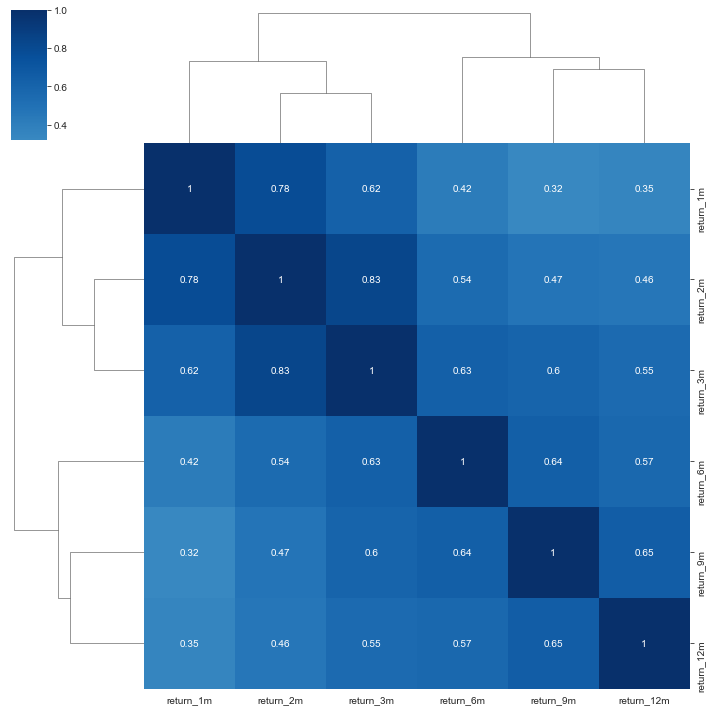

In [13]:
# cmap = sns.diverging_palette(10, 220, as_cmap=True)
sns.clustermap(data.corr('spearman'), annot=True, center=0, cmap='Blues');

In [14]:
# Save plot as jpeg file
plt.savefig('../images/clustermap_01.jpeg')  #TODO: plot is saved as white image. Fix this.

<Figure size 432x288 with 0 Axes>

## Rolling Factor Betas

In [15]:
factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']
factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3', 'famafrench', start='2018')[0].drop('RF', axis=1)
factor_data.index = factor_data.index.to_timestamp()
factor_data = factor_data.resample('M').last().div(100)
factor_data.index.name = 'date'
factor_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 56 entries, 2018-01-31 to 2022-08-31
Freq: M
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Mkt-RF  56 non-null     float64
 1   SMB     56 non-null     float64
 2   HML     56 non-null     float64
 3   RMW     56 non-null     float64
 4   CMA     56 non-null     float64
dtypes: float64(5)
memory usage: 2.6 KB


In [16]:
display(factor_data.head())
display(data.head())

,Mkt-RF,SMB,HML,RMW,CMA
date,,,,,
2018-01-31,0.0557,-0.0321,-0.0133,-0.0072,-0.0100
2018-02-28,-0.0365,0.0031,-0.0107,0.0054,-0.0239
2018-03-31,-0.0235,0.0358,-0.0023,-0.0046,0.0000
2018-04-30,0.0028,0.0093,0.0054,-0.0243,0.0127
2018-05-31,0.0265,0.0474,-0.0318,-0.0204,-0.0147


return_1m  return_2m  return_3m  return_6m  \
symbol timestamp                                                               
TSLA   2018-01-31 00:00:00+00:00   0.140911   0.071956   0.020892   0.015330   
       2018-02-28 00:00:00+00:00  -0.027405   0.053396   0.037756  -0.005083   
       2018-03-31 00:00:00+00:00  -0.246953  -0.144191  -0.058106  -0.044407   
       2018-04-30 00:00:00+00:00   0.132331  -0.076583  -0.060473  -0.020635   
       2018-05-31 00:00:00+00:00  -0.031786   0.047062  -0.061886  -0.013322   

                                  return_9m  return_12m  
symbol timestamp                                         
TSLA   2018-01-31 00:00:00+00:00   0.013295    0.028734  
       2018-02-28 00:00:00+00:00   0.000777    0.027142  
       2018-03-31 00:00:00+00:00  -0.036353   -0.005761  
       2018-04-30 00:00:00+00:00  -0.010594   -0.005673  
       2018-05-31 00:00:00+00:00  -0.024390   -0.015271

In [17]:
data = data.reset_index().rename(columns={'timestamp': 'date'})
data.head()

,symbol,date,return_1m,return_2m,return_3m,return_6m,return_9m,return_12m
0,TSLA,2018-01-31 00:00:00+00:00,0.140911,0.071956,0.020892,0.015330,0.013295,0.028734
1,TSLA,2018-02-28 00:00:00+00:00,-0.027405,0.053396,0.037756,-0.005083,0.000777,0.027142
2,TSLA,2018-03-31 00:00:00+00:00,-0.246953,-0.144191,-0.058106,-0.044407,-0.036353,-0.005761
3,TSLA,2018-04-30 00:00:00+00:00,0.132331,-0.076583,-0.060473,-0.020635,-0.010594,-0.005673
4,TSLA,2018-05-31 00:00:00+00:00,-0.031786,0.047062,-0.061886,-0.013322,-0.024390,-0.015271


In [18]:
data.columns

Index(['symbol', 'date', 'return_1m', 'return_2m', 'return_3m', 'return_6m',
       'return_9m', 'return_12m'],
      dtype='object')

In [19]:
# Create multi-index for 'data' using 'date' and 'symbol' columns
data = data.set_index(['date', 'symbol'])
data.head()

,,return_1m,return_2m,return_3m,return_6m,return_9m,return_12m
date,symbol,,,,,,
2018-01-31 00:00:00+00:00,TSLA,0.140911,0.071956,0.020892,0.015330,0.013295,0.028734
2018-02-28 00:00:00+00:00,TSLA,-0.027405,0.053396,0.037756,-0.005083,0.000777,0.027142
2018-03-31 00:00:00+00:00,TSLA,-0.246953,-0.144191,-0.058106,-0.044407,-0.036353,-0.005761
2018-04-30 00:00:00+00:00,TSLA,0.132331,-0.076583,-0.060473,-0.020635,-0.010594,-0.005673
2018-05-31 00:00:00+00:00,TSLA,-0.031786,0.047062,-0.061886,-0.013322,-0.024390,-0.015271


In [20]:
# Convert 'date' column to tz-unaware datetime format
data.index = data.index.set_levels(data.index.levels[0].to_series().dt.tz_localize(None), level=0)
data.head()

,,return_1m,return_2m,return_3m,return_6m,return_9m,return_12m
date,symbol,,,,,,
2018-01-31,TSLA,0.140911,0.071956,0.020892,0.015330,0.013295,0.028734
2018-02-28,TSLA,-0.027405,0.053396,0.037756,-0.005083,0.000777,0.027142
2018-03-31,TSLA,-0.246953,-0.144191,-0.058106,-0.044407,-0.036353,-0.005761
2018-04-30,TSLA,0.132331,-0.076583,-0.060473,-0.020635,-0.010594,-0.005673
2018-05-31,TSLA,-0.031786,0.047062,-0.061886,-0.013322,-0.024390,-0.015271


In [21]:
factor_data = factor_data.join(data['return_1m']).sort_index()
factor_data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 56 entries, (Timestamp('2018-01-31 00:00:00', freq='M'), 'TSLA') to (Timestamp('2022-08-31 00:00:00', freq='M'), 'TSLA')
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Mkt-RF     56 non-null     float64
 1   SMB        56 non-null     float64
 2   HML        56 non-null     float64
 3   RMW        56 non-null     float64
 4   CMA        56 non-null     float64
 5   return_1m  56 non-null     float64
dtypes: float64(6)
memory usage: 5.4+ KB


In [22]:
display(factor_data.head())
display(factor_data.tail())

,,Mkt-RF,SMB,HML,RMW,CMA,return_1m
date,symbol,,,,,,
2018-01-31,TSLA,0.0557,-0.0321,-0.0133,-0.0072,-0.0100,0.140911
2018-02-28,TSLA,-0.0365,0.0031,-0.0107,0.0054,-0.0239,-0.027405
2018-03-31,TSLA,-0.0235,0.0358,-0.0023,-0.0046,0.0000,-0.246953
2018-04-30,TSLA,0.0028,0.0093,0.0054,-0.0243,0.0127,0.132331
2018-05-31,TSLA,0.0265,0.0474,-0.0318,-0.0204,-0.0147,-0.031786


,,Mkt-RF,SMB,HML,RMW,CMA,return_1m
date,symbol,,,,,,
2022-04-30,TSLA,-0.0946,-0.0040,0.0619,0.0363,0.0592,-0.184100
2022-05-31,TSLA,-0.0034,-0.0006,0.0841,0.0144,0.0398,-0.134256
2022-06-30,TSLA,-0.0843,0.0130,-0.0597,0.0185,-0.0470,-0.114112
2022-07-31,TSLA,0.0957,0.0187,-0.0410,0.0068,-0.0694,0.322140
2022-08-31,TSLA,-0.0378,0.0151,0.0031,-0.0480,0.0131,-0.656628


In [23]:
T = 24
betas = (factor_data.groupby(level='symbol',
                             group_keys=False)
         .apply(lambda x: RollingOLS(endog=x.return_1m,
                                     exog=sm.add_constant(x.drop('return_1m', axis=1)),
                                     window=min(T, x.shape[0]-1))
                .fit(params_only=True)
                .params
                .drop('const', axis=1)))

In [24]:
betas.describe().join(betas.sum(1).describe().to_frame('total'))

,Mkt-RF,SMB,HML,RMW,CMA,total
count,33.000000,33.000000,33.000000,33.000000,33.000000,56.000000
mean,2.793492,-2.142695,0.433338,-5.919274,1.389191,-2.030648
std,0.946387,1.272404,0.698300,3.669183,0.917116,3.318383
min,0.895152,-4.294809,-1.198084,-11.965113,-1.307917,-10.625723
25%,2.038057,-3.400396,0.061830,-8.528832,1.064365,-5.173301
50%,3.178417,-1.954012,0.440359,-5.506098,1.364887,0.000000
75%,3.481479,-1.288091,0.963238,-3.560666,2.022846,0.000000
max,4.195445,0.392167,2.120285,0.670400,3.060763,4.427311


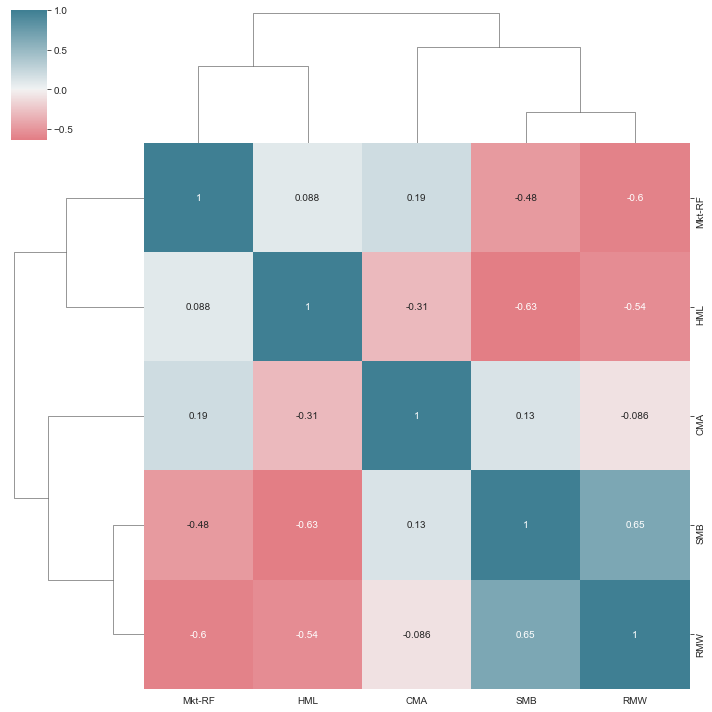

In [25]:
cmap = sns.diverging_palette(10, 220, as_cmap=True)
sns.clustermap(betas.corr(), annot=True, cmap=cmap, center=0);

In [26]:
# Save plot as jpeg file
plt.savefig('../images/clustermap_02.jpeg')  #TODO: plot is saved as white image. Fix this.

<Figure size 432x288 with 0 Axes>

In [27]:
data = (data
        .join(betas
              .groupby(level='symbol')
              .shift()))
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 58 entries, (Timestamp('2018-01-31 00:00:00'), 'TSLA') to (Timestamp('2022-10-31 00:00:00'), 'TSLA')
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   return_1m   58 non-null     float64
 1   return_2m   58 non-null     float64
 2   return_3m   58 non-null     float64
 3   return_6m   58 non-null     float64
 4   return_9m   58 non-null     float64
 5   return_12m  58 non-null     float64
 6   Mkt-RF      32 non-null     float64
 7   SMB         32 non-null     float64
 8   HML         32 non-null     float64
 9   RMW         32 non-null     float64
 10  CMA         32 non-null     float64
dtypes: float64(11)
memory usage: 9.9+ KB


### Impute mean for missing factor betas

In [28]:
data.loc[:, factors] = data.groupby('symbol')[factors].apply(lambda x: x.fillna(x.mean()))
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 58 entries, (Timestamp('2018-01-31 00:00:00'), 'TSLA') to (Timestamp('2022-10-31 00:00:00'), 'TSLA')
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   return_1m   58 non-null     float64
 1   return_2m   58 non-null     float64
 2   return_3m   58 non-null     float64
 3   return_6m   58 non-null     float64
 4   return_9m   58 non-null     float64
 5   return_12m  58 non-null     float64
 6   Mkt-RF      58 non-null     float64
 7   SMB         58 non-null     float64
 8   HML         58 non-null     float64
 9   RMW         58 non-null     float64
 10  CMA         58 non-null     float64
dtypes: float64(11)
memory usage: 9.9+ KB


## Momentum factors

In [29]:
for lag in [2,3,6,9,12]:
    data[f'momentum_{lag}'] = data[f'return_{lag}m'].sub(data.return_1m)
data[f'momentum_3_12'] = data[f'return_12m'].sub(data.return_3m)

## Date Indicators

In [30]:
dates = data.index.get_level_values('date')
data['year'] = dates.year
data['month'] = dates.month

## Lagged returns

In [31]:
for t in range(1, 7):
    data[f'return_1m_t-{t}'] = data.groupby(level='symbol').return_1m.shift(t)
display(data.info())
display(data.head())

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 58 entries, (Timestamp('2018-01-31 00:00:00'), 'TSLA') to (Timestamp('2022-10-31 00:00:00'), 'TSLA')
Data columns (total 25 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   return_1m      58 non-null     float64
 1   return_2m      58 non-null     float64
 2   return_3m      58 non-null     float64
 3   return_6m      58 non-null     float64
 4   return_9m      58 non-null     float64
 5   return_12m     58 non-null     float64
 6   Mkt-RF         58 non-null     float64
 7   SMB            58 non-null     float64
 8   HML            58 non-null     float64
 9   RMW            58 non-null     float64
 10  CMA            58 non-null     float64
 11  momentum_2     58 non-null     float64
 12  momentum_3     58 non-null     float64
 13  momentum_6     58 non-null     float64
 14  momentum_9     58 non-null     float64
 15  momentum_12    58 non-null     float64
 16  momentum_3_12  58 n

None

,,return_1m,return_2m,return_3m,return_6m,return_9m,return_12m,Mkt-RF,SMB,HML,RMW,...,momentum_12,momentum_3_12,year,month,return_1m_t-1,return_1m_t-2,return_1m_t-3,return_1m_t-4,return_1m_t-5,return_1m_t-6
date,symbol,,,,,,,,,,,,,,,,,,,,,
2018-01-31,TSLA,0.140911,0.071956,0.020892,0.015330,0.013295,0.028734,2.778904,-2.221909,0.48432,-6.125201,...,-0.112177,0.007842,2018,1,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-28,TSLA,-0.027405,0.053396,0.037756,-0.005083,0.000777,0.027142,2.778904,-2.221909,0.48432,-6.125201,...,0.054547,-0.010614,2018,2,0.140911,NaN,NaN,NaN,NaN,NaN
2018-03-31,TSLA,-0.246953,-0.144191,-0.058106,-0.044407,-0.036353,-0.005761,2.778904,-2.221909,0.48432,-6.125201,...,0.241192,0.052345,2018,3,-0.027405,0.140911,NaN,NaN,NaN,NaN
2018-04-30,TSLA,0.132331,-0.076583,-0.060473,-0.020635,-0.010594,-0.005673,2.778904,-2.221909,0.48432,-6.125201,...,-0.138004,0.054800,2018,4,-0.246953,-0.027405,0.140911,NaN,NaN,NaN
2018-05-31,TSLA,-0.031786,0.047062,-0.061886,-0.013322,-0.024390,-0.015271,2.778904,-2.221909,0.48432,-6.125201,...,0.016515,0.046615,2018,5,0.132331,-0.246953,-0.027405,0.140911,NaN,NaN


## Target: Holding Period Returns

In [32]:
for t in [1,2,3,6,12]:
    data[f'target_{t}m'] = data.groupby(level='symbol')[f'return_{t}m'].shift(-t)

In [33]:
cols = ['target_1m',
        'target_2m',
        'target_3m', 
        'return_1m',
        'return_2m',
        'return_3m',
        'return_1m_t-1',
        'return_1m_t-2',
        'return_1m_t-3']

data[cols].dropna().sort_index().head(10)

,,target_1m,target_2m,target_3m,return_1m,return_2m,return_3m,return_1m_t-1,return_1m_t-2,return_1m_t-3
date,symbol,,,,,,,,,
2018-04-30,TSLA,-0.031786,0.081991,0.004483,0.132331,-0.076583,-0.060473,-0.246953,-0.027405,0.140911
2018-05-31,TSLA,0.209139,0.023125,0.019365,-0.031786,0.047062,-0.061886,0.132331,-0.246953,-0.027405
2018-06-30,TSLA,-0.134273,-0.064042,-0.082006,0.209139,0.081991,0.098518,-0.031786,0.132331,-0.246953
2018-07-31,TSLA,0.011887,-0.054701,0.042369,-0.134273,0.023125,0.004483,0.209139,-0.031786,0.132331
2018-08-31,TSLA,-0.116907,0.057952,0.051352,0.011887,-0.064042,0.019365,-0.134273,0.209139,-0.031786
2018-09-30,TSLA,0.267436,0.147148,0.077584,-0.116907,-0.054701,-0.082006,0.011887,-0.134273,0.209139
2018-10-31,TSLA,0.038276,-0.006395,-0.033357,0.267436,0.057952,0.042369,-0.116907,0.011887,-0.134273
2018-11-30,TSLA,-0.049143,-0.067299,-0.040863,0.038276,0.147148,0.051352,0.267436,-0.116907,0.011887
2018-12-31,TSLA,-0.085108,-0.036695,-0.056362,-0.049143,-0.006395,0.077584,0.038276,0.267436,-0.116907


## Store data

In [34]:
# Store features in HD5 Datastore
with pd.HDFStore(DATA_STORE) as store:
    store.put('engineered', data, format='table', data_columns=True)
    print(store.info())

<class 'pandas.io.pytables.HDFStore'>
File path: ../../data/assets.h5
/alpaca/SP500/prices            frame        (shape->[1155329,7])                                                                                                                                                                                                                                                                                                                                                                       
/alpaca/tesla/prices            frame        (shape->[934339,7])                                                                                                                                                                                                                                                                                                                                                                        
/engineered                     frame_table  (typ->appendable_multi,nrows->58,nc